In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
save_dir = '/kaggle/working/'
print(f"Using device: {device}")

Using device: cuda


In [4]:
DATASET_PATH = "/kaggle/input/monkeypox-skin-lesion-dataset/Augmented Images/Augmented Images/"
NUM_CLASSES = 2
IMAGE_SIZE = 224
BATCH_SIZE = 64

In [5]:
class ContrastiveDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        img, _ = self.dataset[index]
        img1 = self.transform(img)
        img2 = self.transform(img)
        return img1, img2

    def __len__(self):
        return len(self.dataset)

contrastive_transform = T.Compose([
    T.RandomResizedCrop(size=IMAGE_SIZE),
    T.RandomHorizontalFlip(),
    T.ColorJitter(0.4, 0.4, 0.4, 0.1),
    T.RandomGrayscale(p=0.2),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
train_dataset = ImageFolder(root=DATASET_PATH)
contrastive_dataset = ContrastiveDataset(train_dataset, contrastive_transform)
train_loader = DataLoader(contrastive_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [7]:
class SimCLR(nn.Module):
    def __init__(self, base_model, projection_dim=128):
        super(SimCLR, self).__init__()
        self.encoder = base_model
        self.encoder.fc = nn.Identity()
        self.projection_head = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, projection_dim)
        )

    def forward(self, x):
        features = self.encoder(x)
        projections = self.projection_head(features)
        return projections

model = SimCLR(models.resnet50(pretrained=False)).to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [8]:
def nt_xent_loss(z_i, z_j, temperature=0.5):
    batch_size = z_i.size(0)
    z = torch.cat([z_i, z_j], dim=0)
    z = F.normalize(z, dim=1)
    similarity = torch.matmul(z, z.T) / temperature
    mask = torch.eye(batch_size * 2, dtype=torch.bool).to(z.device)
    similarity = similarity.masked_fill(mask, -9e15)

    positives = torch.diag(similarity, batch_size) + torch.diag(similarity, -batch_size)
    numerator = torch.exp(positives).repeat(2)
    denominator = torch.exp(similarity).sum(dim=1)

    loss = -torch.log(numerator / denominator).mean()
    return loss

In [9]:
optimizer = optim.Adam(model.parameters(), lr=3e-4)
pretext_losses = []
num_pretext_epochs = 80

for epoch in range(num_pretext_epochs):
    model.train()
    total_loss = 0
    for img1, img2 in tqdm(train_loader, desc=f"Pretext Epoch {epoch+1}"):
        img1, img2 = img1.to(device), img2.to(device)
        z1 = model(img1)
        z2 = model(img2)
        loss = nt_xent_loss(z1, z2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    pretext_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}] Pretext Loss: {avg_loss:.4f}")


Pretext Epoch 1: 100%|██████████| 50/50 [01:32<00:00,  1.86s/it]


Epoch [1] Pretext Loss: 2.8250


Pretext Epoch 2: 100%|██████████| 50/50 [01:20<00:00,  1.61s/it]


Epoch [2] Pretext Loss: 2.6641


Pretext Epoch 3: 100%|██████████| 50/50 [01:18<00:00,  1.58s/it]


Epoch [3] Pretext Loss: 2.6127


Pretext Epoch 4: 100%|██████████| 50/50 [01:18<00:00,  1.57s/it]


Epoch [4] Pretext Loss: 2.5358


Pretext Epoch 5: 100%|██████████| 50/50 [01:18<00:00,  1.57s/it]


Epoch [5] Pretext Loss: 2.5629


Pretext Epoch 6: 100%|██████████| 50/50 [01:18<00:00,  1.58s/it]


Epoch [6] Pretext Loss: 2.5496


Pretext Epoch 7: 100%|██████████| 50/50 [01:18<00:00,  1.57s/it]


Epoch [7] Pretext Loss: 2.5496


Pretext Epoch 8: 100%|██████████| 50/50 [01:18<00:00,  1.57s/it]


Epoch [8] Pretext Loss: 2.5022


Pretext Epoch 9: 100%|██████████| 50/50 [01:19<00:00,  1.59s/it]


Epoch [9] Pretext Loss: 2.5154


Pretext Epoch 10: 100%|██████████| 50/50 [01:18<00:00,  1.56s/it]


Epoch [10] Pretext Loss: 2.4723


Pretext Epoch 11: 100%|██████████| 50/50 [01:17<00:00,  1.56s/it]


Epoch [11] Pretext Loss: 2.4713


Pretext Epoch 12: 100%|██████████| 50/50 [01:18<00:00,  1.58s/it]


Epoch [12] Pretext Loss: 2.4577


Pretext Epoch 13: 100%|██████████| 50/50 [01:18<00:00,  1.57s/it]


Epoch [13] Pretext Loss: 2.4705


Pretext Epoch 14: 100%|██████████| 50/50 [01:18<00:00,  1.57s/it]


Epoch [14] Pretext Loss: 2.4637


Pretext Epoch 15: 100%|██████████| 50/50 [01:18<00:00,  1.57s/it]


Epoch [15] Pretext Loss: 2.4206


Pretext Epoch 16: 100%|██████████| 50/50 [01:20<00:00,  1.61s/it]


Epoch [16] Pretext Loss: 2.4318


Pretext Epoch 17: 100%|██████████| 50/50 [01:20<00:00,  1.61s/it]


Epoch [17] Pretext Loss: 2.4213


Pretext Epoch 18: 100%|██████████| 50/50 [01:18<00:00,  1.57s/it]


Epoch [18] Pretext Loss: 2.3950


Pretext Epoch 19: 100%|██████████| 50/50 [01:18<00:00,  1.58s/it]


Epoch [19] Pretext Loss: 2.3981


Pretext Epoch 20: 100%|██████████| 50/50 [01:18<00:00,  1.58s/it]


Epoch [20] Pretext Loss: 2.3456


Pretext Epoch 21: 100%|██████████| 50/50 [01:18<00:00,  1.57s/it]


Epoch [21] Pretext Loss: 2.3324


Pretext Epoch 22: 100%|██████████| 50/50 [01:19<00:00,  1.58s/it]


Epoch [22] Pretext Loss: 2.3687


Pretext Epoch 23: 100%|██████████| 50/50 [01:18<00:00,  1.57s/it]


Epoch [23] Pretext Loss: 2.3819


Pretext Epoch 24: 100%|██████████| 50/50 [01:19<00:00,  1.59s/it]


Epoch [24] Pretext Loss: 2.2738


Pretext Epoch 25: 100%|██████████| 50/50 [01:17<00:00,  1.56s/it]


Epoch [25] Pretext Loss: 2.2485


Pretext Epoch 26: 100%|██████████| 50/50 [01:19<00:00,  1.58s/it]


Epoch [26] Pretext Loss: 2.1934


Pretext Epoch 27: 100%|██████████| 50/50 [01:20<00:00,  1.62s/it]


Epoch [27] Pretext Loss: 2.1169


Pretext Epoch 28: 100%|██████████| 50/50 [01:20<00:00,  1.61s/it]


Epoch [28] Pretext Loss: 2.0980


Pretext Epoch 29: 100%|██████████| 50/50 [01:18<00:00,  1.58s/it]


Epoch [29] Pretext Loss: 2.0806


Pretext Epoch 30: 100%|██████████| 50/50 [01:20<00:00,  1.60s/it]


Epoch [30] Pretext Loss: 2.0544


Pretext Epoch 31: 100%|██████████| 50/50 [01:20<00:00,  1.62s/it]


Epoch [31] Pretext Loss: 2.0631


Pretext Epoch 32: 100%|██████████| 50/50 [01:20<00:00,  1.60s/it]


Epoch [32] Pretext Loss: 2.0244


Pretext Epoch 33: 100%|██████████| 50/50 [01:19<00:00,  1.60s/it]


Epoch [33] Pretext Loss: 2.0077


Pretext Epoch 34: 100%|██████████| 50/50 [01:22<00:00,  1.65s/it]


Epoch [34] Pretext Loss: 2.0361


Pretext Epoch 35: 100%|██████████| 50/50 [01:20<00:00,  1.61s/it]


Epoch [35] Pretext Loss: 1.9906


Pretext Epoch 36: 100%|██████████| 50/50 [01:19<00:00,  1.59s/it]


Epoch [36] Pretext Loss: 1.9871


Pretext Epoch 37: 100%|██████████| 50/50 [01:18<00:00,  1.58s/it]


Epoch [37] Pretext Loss: 1.9806


Pretext Epoch 38: 100%|██████████| 50/50 [01:21<00:00,  1.64s/it]


Epoch [38] Pretext Loss: 1.9531


Pretext Epoch 39: 100%|██████████| 50/50 [01:19<00:00,  1.59s/it]


Epoch [39] Pretext Loss: 1.9450


Pretext Epoch 40: 100%|██████████| 50/50 [01:18<00:00,  1.58s/it]


Epoch [40] Pretext Loss: 1.9346


Pretext Epoch 41: 100%|██████████| 50/50 [01:20<00:00,  1.61s/it]


Epoch [41] Pretext Loss: 1.9209


Pretext Epoch 42: 100%|██████████| 50/50 [01:21<00:00,  1.64s/it]


Epoch [42] Pretext Loss: 1.9128


Pretext Epoch 43: 100%|██████████| 50/50 [01:21<00:00,  1.62s/it]


Epoch [43] Pretext Loss: 1.9044


Pretext Epoch 44: 100%|██████████| 50/50 [01:19<00:00,  1.59s/it]


Epoch [44] Pretext Loss: 1.9005


Pretext Epoch 45: 100%|██████████| 50/50 [01:19<00:00,  1.60s/it]


Epoch [45] Pretext Loss: 1.8935


Pretext Epoch 46: 100%|██████████| 50/50 [01:19<00:00,  1.60s/it]


Epoch [46] Pretext Loss: 1.8778


Pretext Epoch 47: 100%|██████████| 50/50 [01:21<00:00,  1.63s/it]


Epoch [47] Pretext Loss: 1.8904


Pretext Epoch 48: 100%|██████████| 50/50 [01:19<00:00,  1.60s/it]


Epoch [48] Pretext Loss: 1.8745


Pretext Epoch 49: 100%|██████████| 50/50 [01:19<00:00,  1.60s/it]


Epoch [49] Pretext Loss: 1.8718


Pretext Epoch 50: 100%|██████████| 50/50 [01:19<00:00,  1.59s/it]


Epoch [50] Pretext Loss: 1.8581


Pretext Epoch 51: 100%|██████████| 50/50 [01:20<00:00,  1.60s/it]


Epoch [51] Pretext Loss: 1.8552


Pretext Epoch 52: 100%|██████████| 50/50 [01:19<00:00,  1.59s/it]


Epoch [52] Pretext Loss: 1.8691


Pretext Epoch 53: 100%|██████████| 50/50 [01:19<00:00,  1.60s/it]


Epoch [53] Pretext Loss: 1.8409


Pretext Epoch 54: 100%|██████████| 50/50 [01:19<00:00,  1.59s/it]


Epoch [54] Pretext Loss: 1.8259


Pretext Epoch 55: 100%|██████████| 50/50 [01:19<00:00,  1.58s/it]


Epoch [55] Pretext Loss: 1.8239


Pretext Epoch 56: 100%|██████████| 50/50 [01:18<00:00,  1.58s/it]


Epoch [56] Pretext Loss: 1.8313


Pretext Epoch 57: 100%|██████████| 50/50 [01:18<00:00,  1.57s/it]


Epoch [57] Pretext Loss: 1.8252


Pretext Epoch 58: 100%|██████████| 50/50 [01:18<00:00,  1.58s/it]


Epoch [58] Pretext Loss: 1.8190


Pretext Epoch 59: 100%|██████████| 50/50 [01:18<00:00,  1.57s/it]


Epoch [59] Pretext Loss: 1.8033


Pretext Epoch 60: 100%|██████████| 50/50 [01:19<00:00,  1.58s/it]


Epoch [60] Pretext Loss: 1.7839


Pretext Epoch 61: 100%|██████████| 50/50 [01:20<00:00,  1.61s/it]


Epoch [61] Pretext Loss: 1.7445


Pretext Epoch 62: 100%|██████████| 50/50 [01:25<00:00,  1.70s/it]


Epoch [62] Pretext Loss: 1.7612


Pretext Epoch 63: 100%|██████████| 50/50 [01:25<00:00,  1.70s/it]


Epoch [63] Pretext Loss: 1.7694


Pretext Epoch 64: 100%|██████████| 50/50 [01:23<00:00,  1.67s/it]


Epoch [64] Pretext Loss: 1.7560


Pretext Epoch 65: 100%|██████████| 50/50 [01:22<00:00,  1.65s/it]


Epoch [65] Pretext Loss: 1.7565


Pretext Epoch 66: 100%|██████████| 50/50 [01:22<00:00,  1.66s/it]


Epoch [66] Pretext Loss: 1.7423


Pretext Epoch 67: 100%|██████████| 50/50 [01:23<00:00,  1.67s/it]


Epoch [67] Pretext Loss: 1.7448


Pretext Epoch 68: 100%|██████████| 50/50 [01:22<00:00,  1.64s/it]


Epoch [68] Pretext Loss: 1.7364


Pretext Epoch 69: 100%|██████████| 50/50 [01:21<00:00,  1.63s/it]


Epoch [69] Pretext Loss: 1.7223


Pretext Epoch 70: 100%|██████████| 50/50 [01:20<00:00,  1.61s/it]


Epoch [70] Pretext Loss: 1.7131


Pretext Epoch 71: 100%|██████████| 50/50 [01:19<00:00,  1.60s/it]


Epoch [71] Pretext Loss: 1.7164


Pretext Epoch 72: 100%|██████████| 50/50 [01:19<00:00,  1.59s/it]


Epoch [72] Pretext Loss: 1.7031


Pretext Epoch 73: 100%|██████████| 50/50 [01:18<00:00,  1.58s/it]


Epoch [73] Pretext Loss: 1.6712


Pretext Epoch 74: 100%|██████████| 50/50 [01:18<00:00,  1.58s/it]


Epoch [74] Pretext Loss: 1.6949


Pretext Epoch 75: 100%|██████████| 50/50 [01:19<00:00,  1.58s/it]


Epoch [75] Pretext Loss: 1.7234


Pretext Epoch 76: 100%|██████████| 50/50 [01:19<00:00,  1.58s/it]


Epoch [76] Pretext Loss: 1.6906


Pretext Epoch 77: 100%|██████████| 50/50 [01:18<00:00,  1.58s/it]


Epoch [77] Pretext Loss: 1.6687


Pretext Epoch 78: 100%|██████████| 50/50 [01:19<00:00,  1.59s/it]


Epoch [78] Pretext Loss: 1.6516


Pretext Epoch 79: 100%|██████████| 50/50 [01:18<00:00,  1.58s/it]


Epoch [79] Pretext Loss: 1.6838


Pretext Epoch 80: 100%|██████████| 50/50 [01:18<00:00,  1.57s/it]

Epoch [80] Pretext Loss: 1.6719


In [10]:
torch.save(model.state_dict(), os.path.join(save_dir, 'simclr_pretext_resnet50.pth'))

In [11]:
model.load_state_dict(torch.load(os.path.join(save_dir, 'simclr_pretext_resnet50.pth'), map_location=device))

for param in model.encoder.parameters():
    param.requires_grad = False

classifier = nn.Linear(2048, NUM_CLASSES).to(device)
optimizer = optim.Adam(classifier.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

supervised_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
labeled_dataset = ImageFolder(root=DATASET_PATH, transform=supervised_transform)
labeled_loader = DataLoader(labeled_dataset, batch_size=BATCH_SIZE, shuffle=True)

downstream_losses, downstream_accuracies = [], []
num_downstream_epochs = 2

for epoch in range(num_downstream_epochs):
    classifier.train()
    total_loss = 0
    correct, total = 0, 0
    for imgs, labels in tqdm(labeled_loader, desc=f"Classifier Epoch {epoch+1}"):
        imgs, labels = imgs.to(device), labels.to(device)
        features = model.encoder(imgs)
        logits = classifier(features)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    acc = (correct / total) * 100
    downstream_losses.append(total_loss / len(labeled_loader))
    downstream_accuracies.append(acc)
    print(f"Epoch [{epoch+1}] Loss: {total_loss / len(labeled_loader):.4f}, Accuracy: {acc:.2f}%")

torch.save(classifier.state_dict(), os.path.join(save_dir, 'simclr_linear_classifier.pth'))

Classifier Epoch 1: 100%|██████████| 50/50 [00:12<00:00,  4.11it/s]


Epoch [1] Loss: 0.6552, Accuracy: 67.11%


Classifier Epoch 2: 100%|██████████| 50/50 [00:11<00:00,  4.19it/s]

Epoch [2] Loss: 0.5804, Accuracy: 70.02%


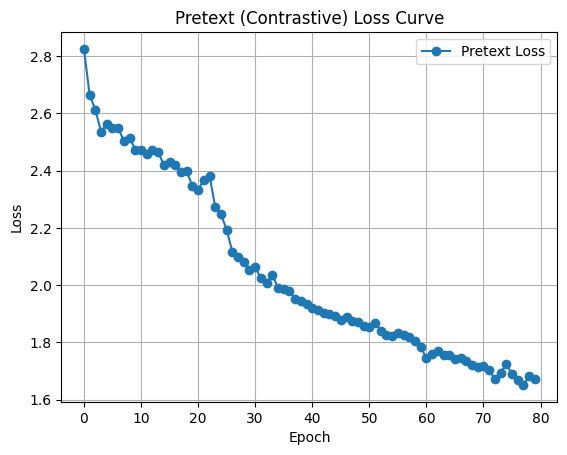

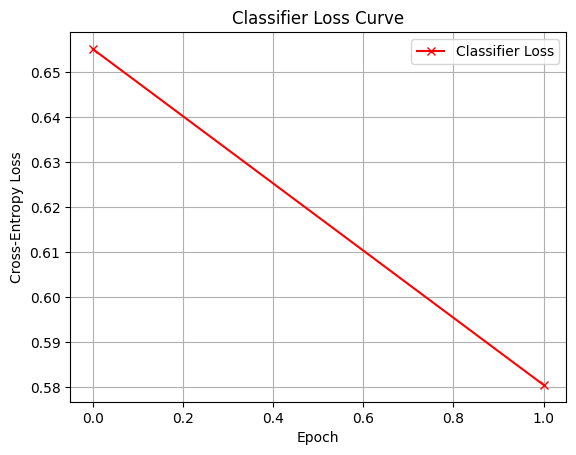

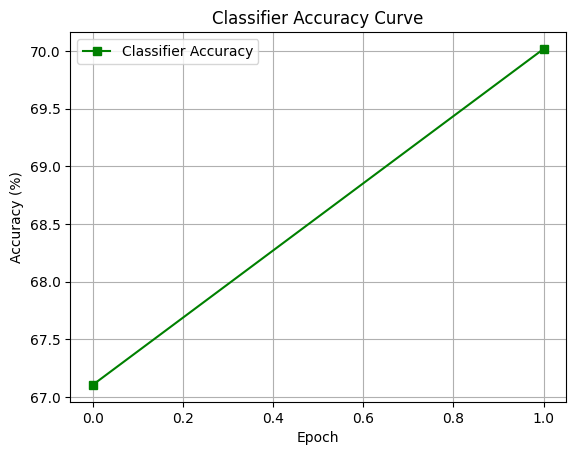

In [12]:
plt.figure()
plt.plot(pretext_losses, marker='o', label='Pretext Loss')
plt.title('Pretext (Contrastive) Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(downstream_losses, marker='x', color='red', label='Classifier Loss')
plt.title('Classifier Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(downstream_accuracies, marker='s', color='green', label='Classifier Accuracy')
plt.title('Classifier Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.show()